In [3]:
import os
import random
from PIL import Image
from typing import Optional, Callable, List
import numpy as np
from scipy import spatial
import seaborn as sns; sns.set_theme(style="whitegrid", palette="pastel")
import matplotlib.pyplot as plt
import pprint

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.models import squeezenet1_1

from dataset import (
    CustomImageNet, CustomStyleNet, CustomMNISTNet, CustomCIFAR10Net, CustomFashionMNISTNet, CustomNovelNet,
    ImageNet2012
)
from utils import inet_classes


seed = 0
torch.backends.cuda.benchmark = True
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

%matplotlib inline

In [4]:
from OTDD.otdd.pytorch.datasets import load_torchvision_data
from OTDD.otdd.pytorch.distance import DatasetDistance, FeatureCost

In [98]:
data_dir = '/home/parantak/Documents/data'
download = True
class_groups = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
load_weights = True
pretrained = True
random = True
dataset = CustomCIFAR10Net
dataset_type = 'cifar105'
device = 'cuda'
layer = 6
dist_type = 'otdd' # otdd/cosine/euclidean

if dataset_type == 'imagenet':
    tick_labels = ['airplane\ncar', 'bird\ncat', 'elephant\ndog', 'bottle\nknife', 'truck\nboat']
    samples_per_class = None # 223 - og
elif dataset_type == 'stylenet':
    tick_labels = ['candy\nmosaic ducks massimo', 'pencil\nseated nude', 'shipwreck\nstarry night', 'stars2\nstrip', 'the scream\nwave']
    samples_per_class = 250 # 250 - og
elif dataset_type == 'mnist':
    tick_labels = ['0, 1', '2, 3', '4, 5', '6, 7', '8, 9']
    samples_per_class = 500 # 500 - og
elif dataset_type == 'cifar10':
    tick_labels = ['airplane\nautomobile', 'bird\ncat', 'deer\ndog', 'frog\nhorse', 'ship\ntruck']
    samples_per_class = 500 # 500 - og
elif dataset_type == 'fashionmnist':
    tick_labels = ['top\ntrouser', 'pullover\ndress', 'coat\nsandal', 'shirt\nsneaker', 'bag\nankleboot']
    samples_per_class = 500 # 500 - og
elif dataset_type == 'novelnet':
    tick_labels = ['fa1', 'fa2', 'fb1', 'fb3', 'fc1']
    samples_per_class = 250 # 250 - og
    class_groups = [[0], [1], [2], [3], [4]]
elif dataset_type == 'fashionmnist5':
    tick_labels = ['top', 'trouser', 'pullover', 'dress', 'coat']
    class_groups = [[0], [1], [2], [3], [4]]
    samples_per_class = 500 # 500 - og
elif dataset_type == 'imagenet5':
    tick_labels = ['airplane', 'car', 'bird', 'cat', 'elephant']
    class_groups = [[0], [1], [2], [3], [4]]
    samples_per_class = None # 223 - og
elif dataset_type == 'mnist5':
    tick_labels = ['0', '1', '2', '3', '4']
    class_groups = [[0], [1], [2], [3], [4]]
    samples_per_class = 500 # 500 - og
elif dataset_type == 'cifar105':
    tick_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer']
    class_groups = [[0], [1], [2], [3], [4]]
    samples_per_class = 500 # 500 - og
elif dataset_type == 'imagenet2012':
    tick_labels = [str(i) for i in range(100)]
    class_groups = [inet_classes[x:x+9] for x in range(0, len(inet_classes), 9)]
    data_dir = '/data'
    samples_per_class = 250

In [99]:
tr_transform, ts_transform = dataset.std_transform['train'], dataset.std_transform['eval']

class_datasets = []
for class_group in class_groups:
    class_datasets.append(dataset(
        root=data_dir, spec_target=class_group, train=True, transform=ts_transform, download=download,
        samples_per_class=samples_per_class
    ))

for idx, dataset in enumerate(class_datasets):
    labels = np.unique(dataset.targets)
    mapping = {}
    for i in range(len(labels)):
        mapping[labels[i]] = i
    dataset.targets = [mapping.get(number, number) for number in dataset.targets]
    dataset.targets = torch.as_tensor(dataset.targets)
    print(len(dataset.targets))
    class_datasets[idx] = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
500
500
500
500
500


In [100]:
embedder = squeezenet1_1(pretrained=pretrained).to(device).eval()
if load_weights:
    checkpoint = torch.load(
        '{}/{}/ImageNet100.pth.tar'.format('/home/parantak/Documents/models/weights', 'SqueezeNet')
    )
    embedder = nn.DataParallel(embedder)
    embedder.module.classifier[1] = nn.Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
    embedder.load_state_dict(checkpoint['state_dict'])
    embedder = embedder.to(device)    

if layer != 12:
    for layer_num in range(layer + 1, 13): 
        embedder.module.features[layer_num] = torch.nn.Identity()
    if layer != 11:
        embedder.module.classifier = torch.nn.Identity()
try:
    embedder.module.fc = torch.nn.Identity()
except AttributeError:
    embedder.fc = torch.nn.Identity()
for p in embedder.parameters():
    p.requires_grad = False

dataset_distances = [[] for _ in range(len(class_groups))]
if dist_type == 'otdd':
    feature_cost = FeatureCost(src_embedding = embedder,
                           src_dim = (3,224,224),
                           tgt_embedding = embedder,
                           tgt_dim = (3,224,224),
                           p = 2,
                           device=device)
    
    for i in range(len(class_groups)):
        for j in range(len(class_groups)):
            if random:
                dist = DatasetDistance(class_datasets[i], class_datasets[j],
                                       inner_ot_method = 'exact',
                                       debiased_loss = True,
                                       p = 2, entreg = 1e-1,
                                       device='cpu')
            else:
                dist = DatasetDistance(class_datasets[i], class_datasets[j],
                                      inner_ot_method = 'exact',
                                      debiased_loss = True,
                                      feature_cost = feature_cost,
                                      sqrt_method = 'spectral',
                                      sqrt_niters=10,
                                      precision='single',
                                      p = 2, entreg = 1e-1,
                                      device=device)

            d = dist.distance()
            dataset_distances[i].append(d)
elif dist_type == 'cosine':
    avg_vectors = []
    for dataset in class_datasets:
        mean_batch_vectors = []
        for batch in dataset:
            mean_batch_vectors.append(torch.mean(embedder(batch[0]), axis=0))
        avg_vectors.append(torch.mean(torch.stack(mean_batch_vectors), axis=0).detach().cpu().numpy())
    for i in range(len(class_groups)):
        for j in range(len(class_groups)):
            dist = spatial.distance.cosine(avg_vectors[i], avg_vectors[j])
            dataset_distances[i].append(dist)
elif dist_type == 'euclidean':
    avg_vectors = []
    for dataset in class_datasets:
        mean_batch_vectors = []
        for batch in dataset:
            mean_batch_vectors.append(torch.mean(embedder(batch[0]), axis=0))
        avg_vectors.append(torch.mean(torch.stack(mean_batch_vectors), axis=0).detach().cpu().numpy())
    for i in range(len(class_groups)):
        for j in range(len(class_groups)):
            dist = spatial.distance.euclidean(avg_vectors[i], avg_vectors[j])
            dataset_distances[i].append(dist)

In [101]:
for lst in dataset_distances:
    for idx, num in enumerate(lst):
        try:
            lst[idx] = num.item()
        except AttributeError:
            lst[idx] = num

dataset_distances_norm = [[float(i)/sum(j) for i in j ]for j in dataset_distances]

<AxesSubplot:>

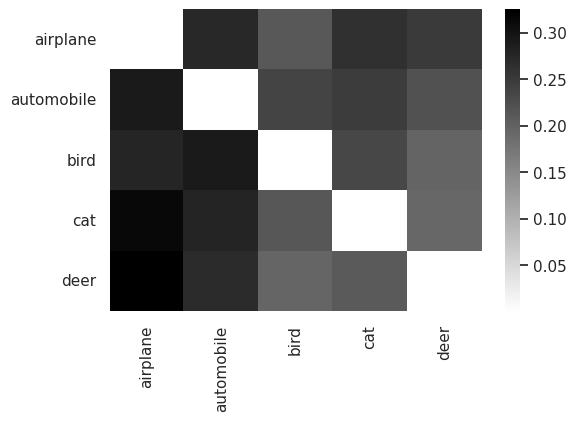

In [102]:
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
sns.heatmap(
    dataset_distances_norm, cmap='binary',
    xticklabels=tick_labels, yticklabels=tick_labels,
    ax=ax,
)

In [103]:
var_dict = {}
sorted_adjacency_list = {}
for el, tick in zip(dataset_distances_norm, tick_labels):
    var_dict[tick] = np.var(el)
    
    sorted_adjacency_list[tick] = []
    for idx, dist in enumerate(el):
        sorted_adjacency_list[tick].append((dist, tick_labels[idx]))
    sorted_adjacency_list[tick].sort(key = lambda x: x[0])
#     sorted_adjacency_list[tick] = [x[1] for x in sorted_adjacency_list[tick]]
    sorted_adjacency_list[tick].pop(0)

sum_var = sum(list(var_dict.values()))
for key, val in var_dict.items():
    var_dict[key] = val / sum_var

In [104]:
pprint.pprint(var_dict)
pprint.pprint(sorted_adjacency_list)

{'airplane': 0.18587931239992533,
 'automobile': 0.18796736394108302,
 'bird': 0.19803528839187762,
 'cat': 0.2121030214592433,
 'deer': 0.21601501380787055}
{'airplane': [(0.21260950224462896, 'bird'),
              (0.25068274400785073, 'deer'),
              (0.26317208318316493, 'cat'),
              (0.27353528088286105, 'automobile')],
 'automobile': [(0.22163060133953771, 'deer'),
                (0.23795881436612212, 'bird'),
                (0.24846594828067436, 'cat'),
                (0.2919442299204218, 'airplane')],
 'bird': [(0.19716497684573356, 'deer'),
          (0.23373433258546517, 'cat'),
          (0.2777919914274211, 'airplane'),
          (0.29130817203222464, 'automobile')],
 'cat': [(0.19338313263076937, 'deer'),
         (0.21381503105681593, 'bird'),
         (0.27824898596160763, 'automobile'),
         (0.3145523648253749, 'airplane')],
 'deer': [(0.19571256770318313, 'bird'),
          (0.20984157020999203, 'cat'),
          (0.2693204235548667, 'automobil